# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

## Notebook 06. Labelled Dataset - Off the shelf sentiment analysing models applied

In this notebook I applied the traditional sentiment analysers models (RoBERTa sentimen module from HuggingFace, and VADER sentiment analyser from NLTK) to the labelled dataset.

The code is adapted from here: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [74]:
#from google.colab import drive
#drive.mount('/content/drive')

In [75]:
#!pip install transformers

In [76]:
# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('ggplot')

# Import NLP libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download necessary datasets for nltk
nltk.download('punkt')          # Tokenizers
nltk.download('vader_lexicon')  # Lexicon for Sentiment Analysis

# Import progress bar utility
from tqdm.notebook import tqdm

# Initialize Sentiment Intensity Analyzer (VADER)
sia = SentimentIntensityAnalyzer()

# RoBERTa Sentiment Analyzer packages
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

[nltk_data] Downloading package punkt to /Users/lgfolder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lgfolder/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [77]:
from transformers import pipeline

# Define the model path
model_path = "cardiffnlp/twitter-roberta-base-sentiment"

# Load the sentiment analysis pipeline
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

In [78]:
# Perform sentiment analysis
result = sentiment_task("only loosers would buy gamestop")

print(result)

[{'label': 'LABEL_1', 'score': 0.542090654373169}]


In [79]:
# Perform sentiment analysis
result = sentiment_task("only loosers would sell gamestop")

print(result)

[{'label': 'LABEL_1', 'score': 0.5940859913825989}]


In [80]:
# Read in data
df = pd.read_csv('../data/02_labelled_dataset_wo_emoji.csv')
print(df.shape)
#df = df.head(1000)
#print(df.shape)

(4996, 8)


In [81]:
df.head()

,link_id,parent_id,User,Text,Intent,Support,word_count,emoji_text
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,i,i,12,NaN
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",u,u,4,NaN
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",u,n,12,NaN
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent double down posted? 9 bill...,u,u,64,NaN
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,y,u,6,NaN


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   word_count  4996 non-null   int64 
 7   emoji_text  742 non-null    object
dtypes: int64(1), object(7)
memory usage: 312.4+ KB


In [83]:
df['Idx'] = df.index

In [84]:
#df = df.rename(columns={'Unnamed: 0': 'Idx'}) - for csv files with emojis

In [85]:
# Check if there are any missing values in the 'Text' column
print("Missing values in 'Text' column:", df['Text'].isnull().sum())

Missing values in 'Text' column: 0


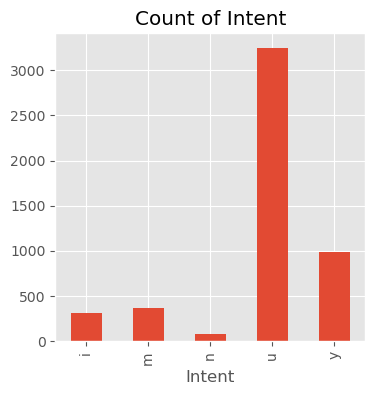

In [86]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

In [128]:
example = df['Text'][4]
print(example)

Just got into $GME @ 220.


In [129]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Just got into $GME @ 220.


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

# RoBERTa and VADER sentiment analyser

In [89]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Load the RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [90]:
# Maximum token limit for the RoBERTa model
max_token_limit = tokenizer.model_max_length

# Iterate through the DataFrame rows to check whether text exceeds maximum number of tokens
for index, row in df.iterrows():
    text = row['Text']
    # Tokenize the text
    tokens = tokenizer(text, return_tensors="pt")
    # Get the number of tokens in the text
    num_tokens = len(tokens['input_ids'][0])
    
    # Check if the number of tokens exceeds the maximum limit
    if num_tokens > max_token_limit:
        print(f"Row {index} has too many tokens ({num_tokens} tokens):")
        print(text)

In [91]:
# Sample text for tokenization
sample_text = "only losers would buy gamestop"

# Tokenize the sample text
tokens = tokenizer(sample_text, return_tensors="pt")
print(tokens)

{'input_ids': tensor([[    0,  8338, 19113,    74,   907, 20577,   990,  1517,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Code to check the model input:

In [92]:
# Example input tensor (replace with your tokenized input)
input_ids = tokens["input_ids"][0]  # Input_ids is a tensor that contains the token IDs of the tokenized input text
attention_mask = tokens["attention_mask"] # tells the model which tokens are "real" words and which ones are padding tokens

# Ensure the input tensor shape matches the model's input requirements
print("Input IDs shape:", input_ids.shape)
print("Attention mask shape:", attention_mask.shape)

# Forward pass through the model to get predictions (for debugging)
output = model(input_ids.unsqueeze(0), attention_mask=attention_mask) # applies the model to the input, adding an extra dimension to the tensor to make it compatible with batch processing, where the batch size is 1
print("Model output:", output)


Input IDs shape: torch.Size([9])
Attention mask shape: torch.Size([1, 9])
Model output: SequenceClassifierOutput(loss=None, logits=tensor([[ 1.9040,  0.2803, -2.1438]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [93]:
# Run for Roberta Model for one example to test it
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.18812548, 'roberta_neu': 0.6091106, 'roberta_pos': 0.20276392}


In [94]:
# Define RoBERTa function to iterate through df rows

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [95]:
# VADER and RoBERTa sentiment - to label the recordswith sentiment ratings (takes a long time!)
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Idx']  # Use the 'Idx' column as the identifier
        vader_result = sia.polarity_scores(text)  # SIA polarity scores
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)  # RoBERTa results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for index {i}')

  0%|          | 0/4996 [00:00<?, ?it/s]

Broke for index 39
Broke for index 182
Broke for index 366
Broke for index 767
Broke for index 975
Broke for index 1059
Broke for index 1095
Broke for index 1104
Broke for index 1117
Broke for index 1132
Broke for index 1155
Broke for index 1172
Broke for index 1417
Broke for index 2024
Broke for index 2229
Broke for index 2651
Broke for index 2658
Broke for index 2985
Broke for index 3062
Broke for index 3104
Broke for index 3118
Broke for index 3255
Broke for index 3264
Broke for index 3596
Broke for index 3852
Broke for index 4075
Broke for index 4155
Broke for index 4251
Broke for index 4261
Broke for index 4733
Broke for index 4916


In [96]:
# Recording the results in new columns in results_df
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Idx'})  
results_df = results_df.merge(df, how='left')

In [97]:
# Check for missing values in the merged DataFrame (results_df)
missing_values = results_df.isnull().sum()
print("Missing values in the merged DataFrame:")
print(missing_values)

Missing values in the merged DataFrame:
Idx                  0
vader_neg            0
vader_neu            0
vader_pos            0
vader_compound       0
roberta_neg          0
roberta_neu          0
roberta_pos          0
link_id              0
parent_id            0
User                 0
Text                 0
Intent               0
Support              0
word_count           0
emoji_text        4247
dtype: int64


In [98]:
results_df.head(10)

,Idx,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,link_id,parent_id,User,Text,Intent,Support,word_count,emoji_text
0,0,0.000,1.000,0.000,0.0000,0.077612,0.861043,0.061345,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,i,i,12,NaN
1,1,0.464,0.536,0.000,-0.3802,0.757429,0.207618,0.034953,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",u,u,4,NaN
2,2,0.208,0.792,0.000,-0.4389,0.188125,0.609111,0.202764,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",u,n,12,NaN
3,3,0.000,0.841,0.159,0.8555,0.403425,0.465120,0.131455,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent double down posted? 9 bill...,u,u,64,NaN
4,4,0.000,1.000,0.000,0.0000,0.016767,0.866622,0.116611,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,y,u,6,NaN
5,5,0.000,0.592,0.408,0.9081,0.001821,0.038957,0.959221,t3_lx47v2,t3_lx47v2,not_chickentarian,GME went up to 131$ in AH and is now breaking ...,u,y,19,🚀 🚀
6,6,0.000,0.139,0.861,0.9914,0.001094,0.021993,0.976913,t3_l2lfqs,t3_l2lfqs,bigtastysauce,Just doubled my position on GMELet’s HOLDDDDDD...,y,y,8,🔥 🔥 🔥 🔥 🔥 🔥 🚀 🚀 🚀 🚀 🚀 🚀 🚀
7,7,0.143,0.857,0.000,-0.5411,0.596437,0.365049,0.038515,t3_l68y04,t3_l68y04,radehart,"Do not sell GME, BUY THE DIP! Big Money will ...",u,y,22,NaN
8,8,0.000,1.000,0.000,0.0000,0.085476,0.868586,0.045938,t3_kjyzh7,t3_kjyzh7,Additional_Still5612,Do you currently still plan on getting back in...,u,u,31,NaN
9,9,0.082,0.723,0.195,0.7548,0.316744,0.516255,0.167002,t3_l7wprt,t3_l7wprt,B_Sho,I am not giving into the hype yet. I want to ...,m,u,70,NaN


In [99]:
# Checking the value counts again
value_counts = results_df['Intent'].value_counts()
print(value_counts)

Intent
u    3226
y     982
m     368
i     306
n      83
Name: count, dtype: int64


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


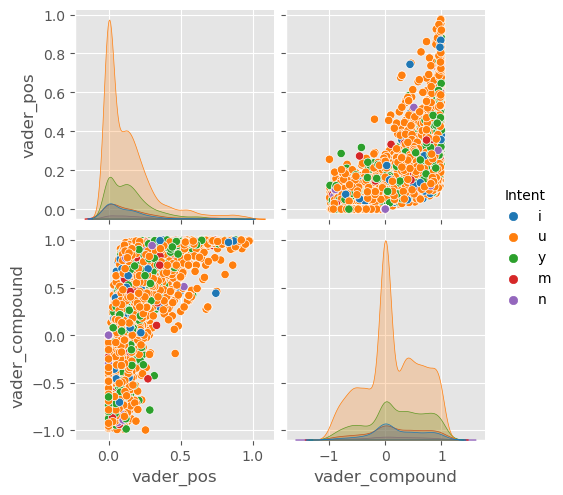

In [100]:
sns.pairplot(data=results_df,
             vars=['vader_pos',
                   'vader_compound'],
            hue='Intent',
            palette='tab10')
plt.show()

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


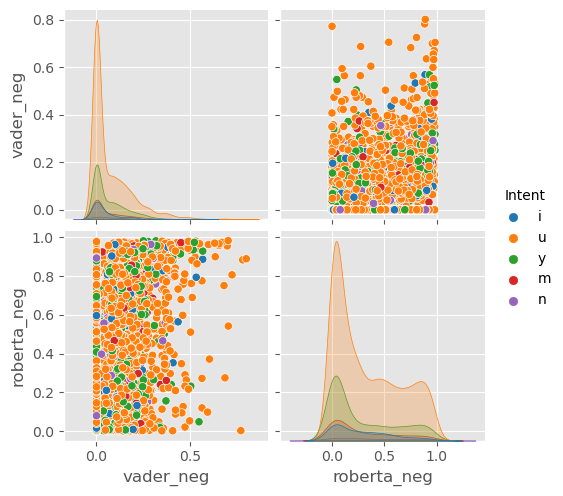

In [101]:
sns.pairplot(data=results_df,
             vars=['vader_neg',
                  'roberta_neg'],
            hue='Intent',
            palette='tab10')
plt.show()

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


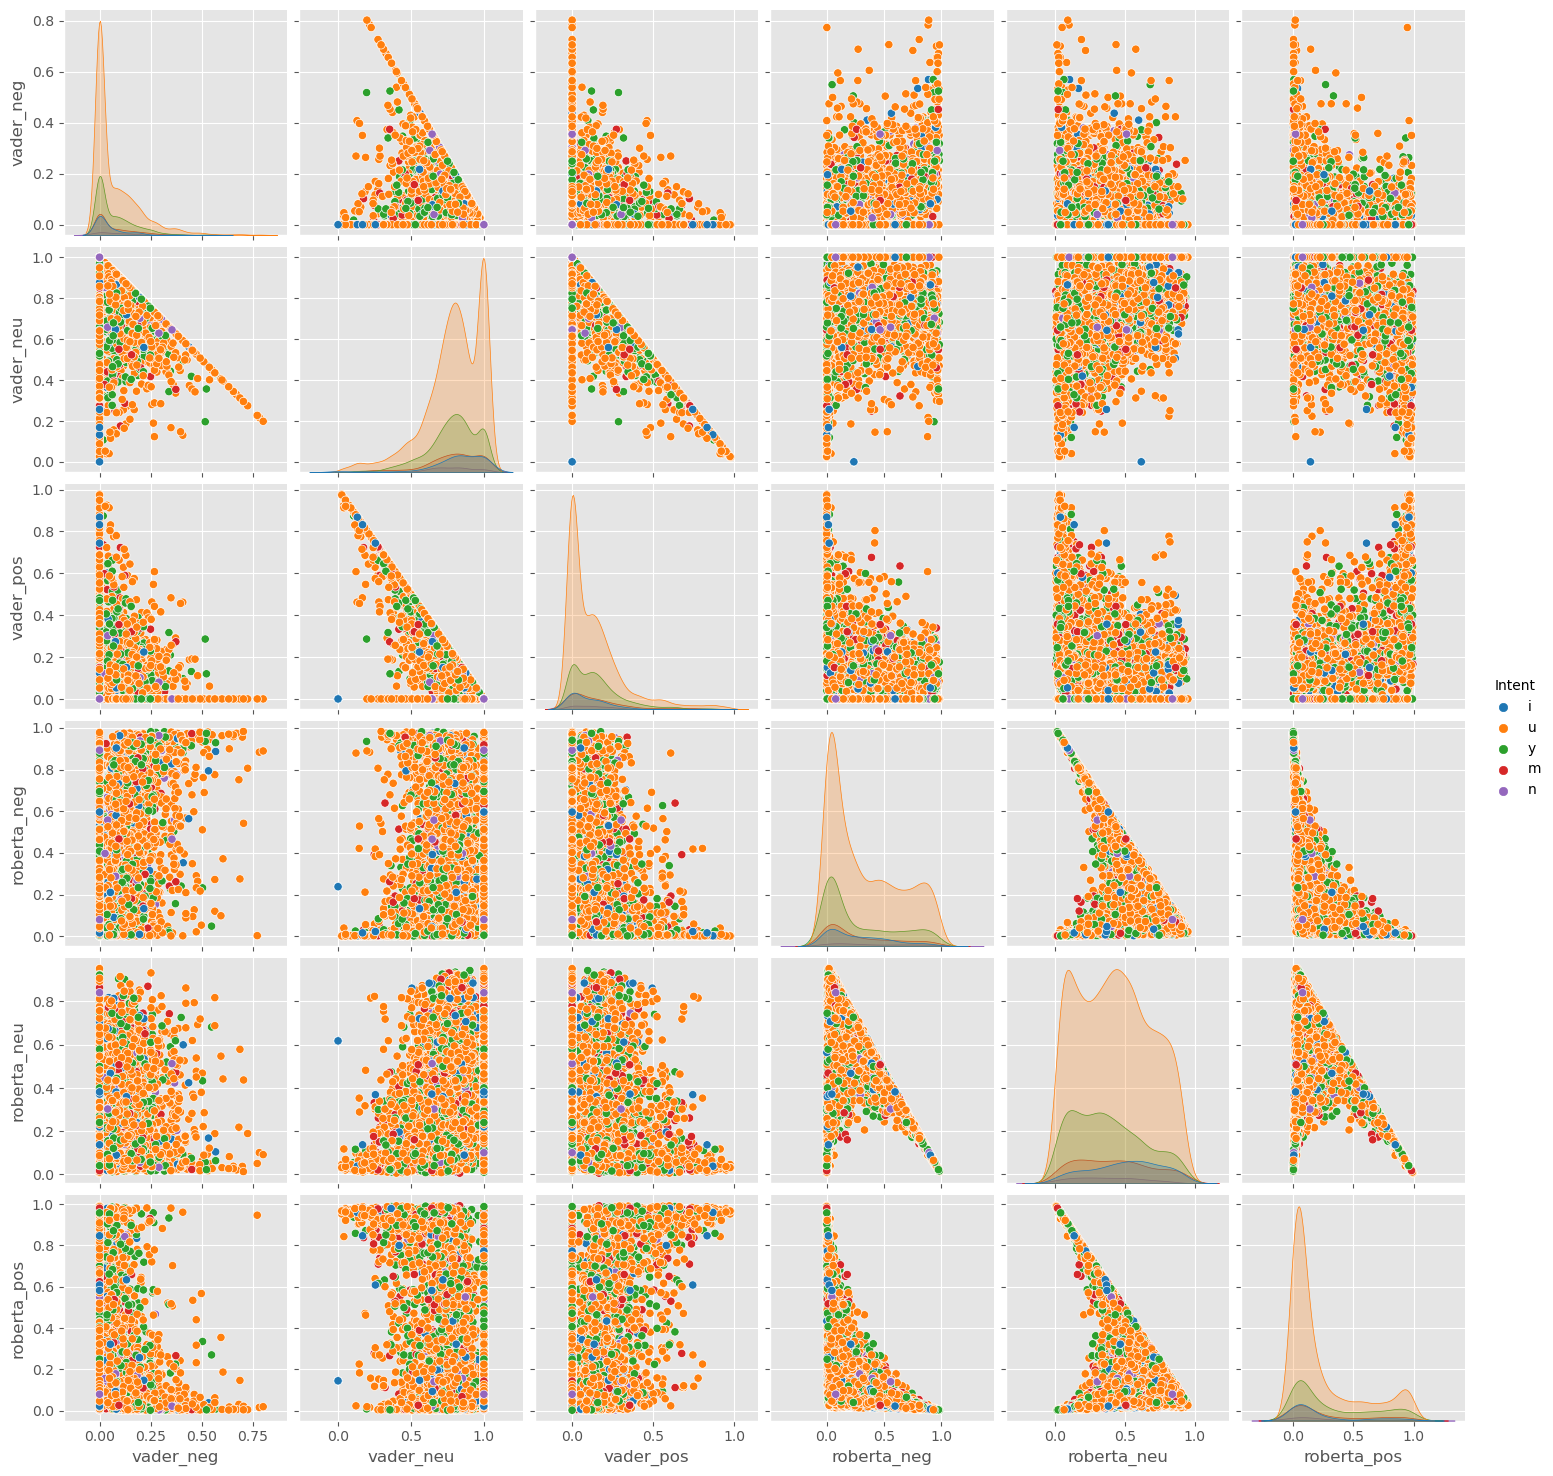

In [102]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Intent',
            palette='tab10')
plt.show()

Examples of positive sentiment identified correctly:

In [103]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"Just bought 1 share on Fidelity. I'm proud to be part of this with you all. Gamestop has a bright future and I REALLY LIKE THE STOCK!!!"

In [104]:
results_df.query('Intent == "y"') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

"Exercised my GME calls instead of selling them, now I'm on margin waiting for my paycheck.   DIAMOND FUCKING HANDS  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,  super optimistic,   super optimistic, "

Examples of negative sentiment identified correctly:

In [105]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[1]

'FML FML FML New AOT chapter is shit and I’m in meltdown mode like GME bag holders'

In [106]:
results_df.query('Intent == "n"') \
    .sort_values('vader_neg', ascending=False)['Text'].values[1]

"if you mean pumping till $500 then losing 75%, then no it ain't no GME."

Below are examples of misclassifications:

In [107]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"Why does citron fuck with every ticker I'm in. Nio, then pltr, now gme. Fuck those guys."

In [108]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This is the best day of my life. Never bought any options before but with GME pumped up so high bought puts on Friday. Cashed those babies in today for a 30k profit!'

In [109]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [133]:
# VADER results on example
example = 'Exactly, oh well people thumbing this shit down just want to pump their bags and cash out on call premiums convincing people to buy them because”SQUEEZE WILL HAPPEN ANY DAY NOW GME $1000”. I feel bad, but mehhhhh, as more people blow up their accounts I hope a large chunk of them think twice about buying into a dead play. Oh well'
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

Exactly, oh well people thumbing this shit down just want to pump their bags and cash out on call premiums convincing people to buy them because”SQUEEZE WILL HAPPEN ANY DAY NOW GME $1000”. I feel bad, but mehhhhh, as more people blow up their accounts I hope a large chunk of them think twice about buying into a dead play. Oh well
[{'label': 'NEGATIVE', 'score': 0.9977630376815796}]
{'neg': 0.146, 'neu': 0.662, 'pos': 0.191, 'compound': 0.0836}


In [156]:
example1 = "Just got into $GME @ 220."
print(example)

# ROBERTA results on the example
print(sent_pipeline(example1))

# VADER results on the example
print(sia.polarity_scores(example1))

Just got into $GME @ 220.
[{'label': 'NEGATIVE', 'score': 0.9975746273994446}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [134]:
example = "PLEASE DON'T BE SMART AND SELL GME"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

PLEASE DON'T BE SMART AND SELL GME
[{'label': 'NEGATIVE', 'score': 0.9995328187942505}]
{'neg': 0.236, 'neu': 0.523, 'pos': 0.241, 'compound': 0.0108}


In [139]:
example = "PLEASE DON'T BE SMART AND BUY GME"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

PLEASE DON'T BE SMART AND BUY GME
[{'label': 'NEGATIVE', 'score': 0.9993476271629333}]
{'neg': 0.236, 'neu': 0.523, 'pos': 0.241, 'compound': 0.0108}


In [140]:
example = "only loosers would buy gamestop"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

only loosers would buy gamestop
[{'label': 'NEGATIVE', 'score': 0.9890828132629395}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [141]:
example = "only loosers would sell gamestop"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

only loosers would sell gamestop
[{'label': 'NEGATIVE', 'score': 0.9728075265884399}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [142]:
example = "🚀🚀🚀🚀🚀🚀🚀"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

🚀🚀🚀🚀🚀🚀🚀
[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [152]:
example = "to the moon!"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

to the moon!
[{'label': 'POSITIVE', 'score': 0.9993788003921509}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [154]:
example = "super optimistic!"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

super optimistic!
[{'label': 'POSITIVE', 'score': 0.9997383952140808}]
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.7574}


In [146]:
example = "🌙"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

🌙
[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}


In [145]:
example = "💎🙌"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

💎🙌
[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [151]:
example = "patient investors"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

patient investors
[{'label': 'POSITIVE', 'score': 0.9970734119415283}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [147]:
example = "apes 🦍"
print(example)

# ROBERTA results on the example
print(sent_pipeline(example))

# VADER results on the example
print(sia.polarity_scores(example))

apes 🦍
[{'label': 'NEGATIVE', 'score': 0.7105820775032043}]
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [155]:
example = "WE ARE PLUS 430!!! 🌙  🦍 WE ARE DOING IT. NOW KEEP HOLDING AND DONT GIVE INTO WHAT THEY WANT. IT WILL BE 600 BEFORE THE DAYS OUT AND THEN MONDAY IT WILL OPEN AT $1000 🤞 IF NOT THEN JUST A LITTLE LESS. BUY BUY BUY PEOPLE THIS IS STILL ONLY THE BEGINNING!!! AND DONT SELL WHEN YOU SEE THE DROP THIS MORNING THIS IS WHAT THEY WANT YOU TO DO AND THEN THEY WILL MAKE IT SO YOU CAN BUY ANYMORE STOCKS OR GAME STOP LIKE THEY DONE YESTERDAY BUT WE ARE NOT STUPID!! HOLDING AND NOT SELLING AND BUYING MORE HERE WHEN LAME ASS ROBINHOOD OPENS. HOLD HOLD HOLD. TO THE MOON🚀🚀🚀🚀🚀🚀🚀"
print(example)
print(sent_pipeline(example))
print(sia.polarity_scores(example))

WE ARE PLUS 430!!! 🌙  🦍 WE ARE DOING IT. NOW KEEP HOLDING AND DONT GIVE INTO WHAT THEY WANT. IT WILL BE 600 BEFORE THE DAYS OUT AND THEN MONDAY IT WILL OPEN AT $1000 🤞 IF NOT THEN JUST A LITTLE LESS. BUY BUY BUY PEOPLE THIS IS STILL ONLY THE BEGINNING!!! AND DONT SELL WHEN YOU SEE THE DROP THIS MORNING THIS IS WHAT THEY WANT YOU TO DO AND THEN THEY WILL MAKE IT SO YOU CAN BUY ANYMORE STOCKS OR GAME STOP LIKE THEY DONE YESTERDAY BUT WE ARE NOT STUPID!! HOLDING AND NOT SELLING AND BUYING MORE HERE WHEN LAME ASS ROBINHOOD OPENS. HOLD HOLD HOLD. TO THE MOON🚀🚀🚀🚀🚀🚀🚀
[{'label': 'NEGATIVE', 'score': 0.7619146108627319}]
{'neg': 0.132, 'neu': 0.794, 'pos': 0.074, 'compound': -0.8875}


In [120]:
# Recording the processed dataset as a new csv file to be used in future:
results_df.to_csv('../data/06_labelled_dataset_VADER.csv', index=False)

In [165]:
examples.head(15)

,text,label,score,neg,neu,pos,compound
0,Just got into $GME @ 220.,NEGATIVE,0.997575,0.000,1.000,0.000,0.0000
1,PLEASE DON'T BE SMART AND SELL GME,NEGATIVE,0.999533,0.236,0.523,0.241,0.0108
2,PLEASE DON'T BE SMART AND BUY GME,NEGATIVE,0.999348,0.236,0.523,0.241,0.0108
3,only loosers would buy gamestop,NEGATIVE,0.989083,0.000,1.000,0.000,0.0000
4,only loosers would sell gamestop,NEGATIVE,0.972808,0.000,1.000,0.000,0.0000
5,🚀🚀🚀🚀🚀🚀🚀,NEGATIVE,0.697056,0.000,1.000,0.000,0.0000
6,to the moon!,POSITIVE,0.999379,0.000,1.000,0.000,0.0000
7,super optimistic!,POSITIVE,0.999738,0.000,0.000,1.000,0.7574
8,🌙,NEGATIVE,0.697056,0.000,0.000,0.000,0.0000
9,💎🙌,NEGATIVE,0.697056,0.000,1.000,0.000,0.0000


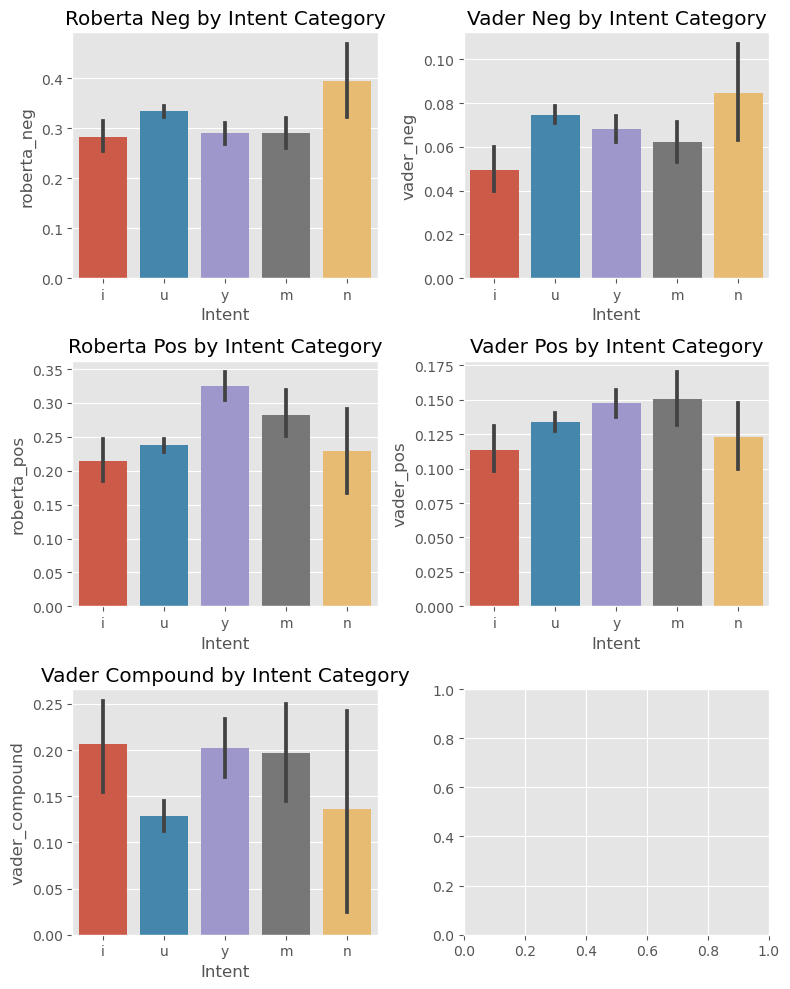

In [124]:
# Plotting graphs to show the distribution of Vader ratings
fig, axes = plt.subplots(3, 2, figsize=(8, 10))


sns.barplot(ax=axes[0, 0], data=results_df, x='Intent', y='roberta_neg')
axes[0, 0].set_title('Roberta Neg by Intent Category')

sns.barplot(ax=axes[0, 1], data=results_df, x='Intent', y='vader_neg')
axes[0, 1].set_title('Vader Neg by Intent Category')

sns.barplot(ax=axes[1, 0], data=results_df, x='Intent', y='roberta_pos')
axes[1, 0].set_title('Roberta Pos by Intent Category')

sns.barplot(ax=axes[1, 1], data=results_df, x='Intent', y='vader_pos')
axes[1, 1].set_title('Vader Pos by Intent Category')

sns.barplot(ax=axes[2, 0], data=results_df, x='Intent', y='vader_compound')
axes[2, 0].set_title('Vader Compound by Intent Category')


plt.tight_layout()
plt.show()

In [125]:
#fig.savefig('../data/labelled_RoBERTa_sentiment_noemoji.png', dpi=120)

Conclusions:

Off-she shelf sentiment analysers work pretty well for traditional consumer reviews - hotels, movies, etc.  I analysed the wallstreetbets chatter using these tools (VADER and RoBERTa).  The results are pretty disappointing, as the distribution of negative and positive sentiment is pretty much homogeneous across all 5 categories of labels.  When I analyse the frequency charts of the assigned sentiment, I don’t see any clearly separated distributions across categories. 

Looking deeper into the sentiment ratings given to various sentences helps to identify the problem.  The traditional sentiment analysers have not been trained to distinguish the difference between the words "buy" and "sell", for example. they also don’t understand the meaning of emojis.  Encoding emojis with "normal English" did not help to improve the performance of the traditional sentiment analysers.   

**The main takeaway: the traditional sentiment analysers don’t work at all if our goal is to understand investment related opinions/recommendations.**
